# Week 10 - Ensemble Learning: Random Forests and Boosting

Last week, we saw that **bagging** (**b**ootstrap **agg**regation) averages multiple classifiers or regressors fitted to different bootstrapped data samples, which has the effect of reducing the variance of the individual models and regularizing their fits to improve generalization (test performance).

This week, we continue our work with ensemble models, of which bagging is a special case. All ensembles are involved with training multiple supervised ML models and combining their predictions such that performance of the whole is better than any of the individual parts.

Let's consider classification first.

In classification, ensembles are generally better than their parts (the individual classifiers) if some of the following three properties are satisfied:

1. Classifiers are **accurate** (better than random guessing)
2. Classifiers are **diverse** (make mistakes on *different* examples)
3. Classifiers are **cheap** (each is not too computationally costly)

The situation with regression is similar, but errors are smooth rather than binary, so ideal regressors for ensembles have somewhat low error, have errors dispersed differently across the test set, and can be trained cheaply.

Decision trees satisfy all three conditions. Trees are not the most accurate models, but they do learn (**accurate**). Trees have very high variance (**diverse**). Trees train in very little time, so ensembles of thousands of trees are viable (**cheap**). As such, trees are ideal classifiers for ensembling.

It should be noted that ensembling can be useful even if some of the conditions above are net met: for example, neural networks are very expensive to train, but they are accurate and diverse, and we do see smaller but substantial performance gains from ensembling neural networks.

We cover two sub-topics this week:

1. **Random forests** uses bagging with *de-correlated* trees to solve overfitting more effectively than simple bagging.
2. **Boosting** throws out bootstrapping in favor of sequential samples that push the individual models to focus on points where the model makes errors. This is primarily used to solve underfitting.

Each of these represent state-of-the-art models for the types of data where they are most effective.

# Lecture 18 - Random Forests

**Recommended reading**: The short Ch 15 from *Elements of Statistical Learning*

Today, we cover **random forests**. A random forest is made up of bagged decision trees which train only on random subsets of the featues of the training data as inputs. This has the effect of making the trees less correlated to one another, which allows the ensemble to have lower variance than the individual models -- and lower than simple bagged trees. This has an exceptional regularizing effect (i.e. it improves generalization to test data).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10

## Example: Breast Cancer Classification

In [2]:
cancer = load_breast_cancer()

print(cancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi


Training Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       266

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.94      0.90      0.92        52
           1       0.95      0.97      0.96        91

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

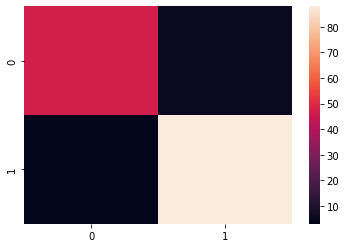

<Figure size 432x288 with 0 Axes>

In [3]:
X = cancer['data']
Y = cancer['target']

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the classifier
model = RandomForestClassifier(n_jobs = -1)

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Random forests offer some criteria for ranking the importance of various features. Next, let's use the `permutation_importance` method to evaluate the importance of each feature to the classification.

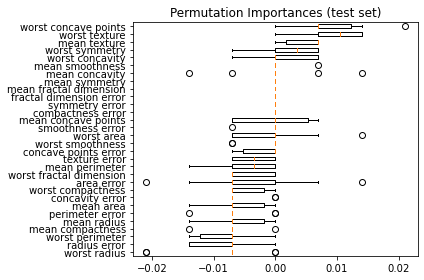

In [6]:
result = permutation_importance(model, testX, testY, n_repeats = 10, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = cancer.feature_names[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### MNIST Example


Training Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      1.00      1.00      6742
           2       1.00      1.00      1.00      5958
           3       1.00      1.00      1.00      6131
           4       1.00      1.00      1.00      5842
           5       1.00      1.00      1.00      5421
           6       1.00      1.00      1.00      5918
           7       1.00      1.00      1.00      6265
           8       1.00      1.00      1.00      5851
           9       1.00      1.00      1.00      5949

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
         

<Figure size 432x288 with 0 Axes>

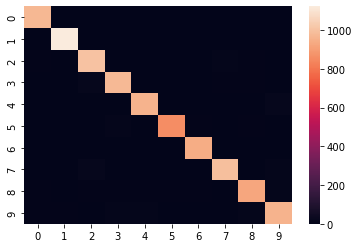

<Figure size 432x288 with 0 Axes>

In [9]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# preprocess the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
trainX = trainX.astype('float')/255.0

testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])
testX = testX.astype('float')/255.0

# build the classifier
model = RandomForestClassifier(n_jobs = -1)

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

### CIFAR10 Example

C:\Users\Ryan\AppData\Local\Temp/ipykernel_26572/2308665654.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(trainX, trainY)



Training Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      5000
           2       1.00      1.00      1.00      5000
           3       1.00      1.00      1.00      5000
           4       1.00      1.00      1.00      5000
           5       1.00      1.00      1.00      5000
           6       1.00      1.00      1.00      5000
           7       1.00      1.00      1.00      5000
           8       1.00      1.00      1.00      5000
           9       1.00      1.00      1.00      5000

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.54      0.58      0.56      1000
           1       0.52      0.54      0.53      1000
         

<Figure size 432x288 with 0 Axes>

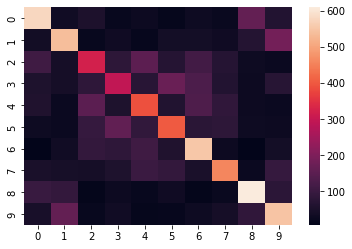

<Figure size 432x288 with 0 Axes>

In [13]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

# preprocess the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2] * 3)
trainX = trainX.astype('float')/255.0

testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2] * 3)
testX = testX.astype('float')/255.0

# build the classifier
model = RandomForestClassifier(n_jobs = -1)

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

### OOB Example

C:\Users\Ryan\anaconda3\envs\ML\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Ryan\anaconda3\envs\ML\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Ryan\anaconda3\envs\ML\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


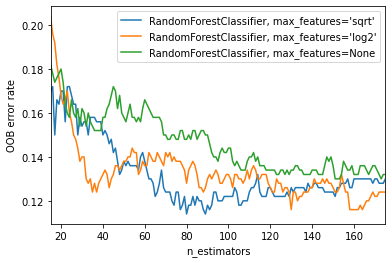

In [12]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=0)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=0)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=0)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=0))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

# Lecture 19 - Boosting and AdaBoost

First, let's import some things.

In [39]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier


Training Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       266

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.98      0.92      0.95        52
           1       0.96      0.99      0.97        91

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

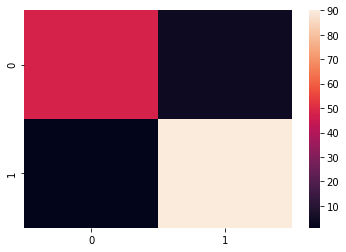

<Figure size 432x288 with 0 Axes>

In [30]:
data = load_breast_cancer()

X = data['data']
Y = data['target']

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the classifier
model = AdaBoostClassifier()

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()


Training Classification Report:

               precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.98      0.95      0.97        60
           2       1.00      1.00      1.00        33

    accuracy                           0.97       133
   macro avg       0.97      0.97      0.97       133
weighted avg       0.97      0.97      0.97       133


Testing Classification Report:

               precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.73      1.00      0.85        11
           2       1.00      0.80      0.89        15

    accuracy                           0.91        45
   macro avg       0.91      0.92      0.90        45
weighted avg       0.93      0.91      0.91        45


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

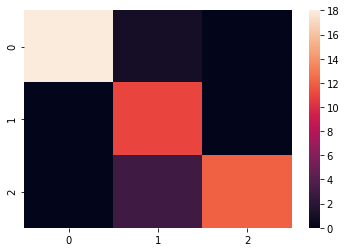

<Figure size 432x288 with 0 Axes>

In [34]:
data = load_wine()

X = data['data']
Y = data['target']

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the classifier
model = AdaBoostClassifier()

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Let's try the MNIST dataset with AdaBoost.


Training Classification Report:

               precision    recall  f1-score   support

           0       0.81      0.90      0.86      5923
           1       0.83      0.94      0.88      6742
           2       0.78      0.55      0.65      5958
           3       0.74      0.58      0.65      6131
           4       0.75      0.78      0.77      5842
           5       0.68      0.64      0.66      5421
           6       0.68      0.87      0.76      5918
           7       0.74      0.72      0.73      6265
           8       0.67      0.70      0.68      5851
           9       0.63      0.61      0.62      5949

    accuracy                           0.73     60000
   macro avg       0.73      0.73      0.73     60000
weighted avg       0.73      0.73      0.73     60000


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.82      0.90      0.86       980
           1       0.84      0.95      0.89      1135
         

<Figure size 432x288 with 0 Axes>

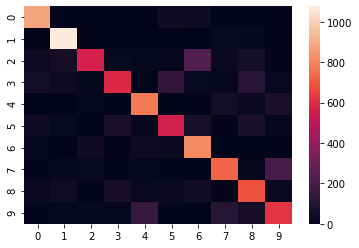

<Figure size 432x288 with 0 Axes>

In [12]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# preprocess the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
trainX = trainX.astype('float')/255.0

testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])
testX = testX.astype('float')/255.0

# build the classifier
model = AdaBoostClassifier(n_estimators = 100)

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Let's make the individual classifiers a little more sophisticated.


Training Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      1.00      1.00      6742
           2       1.00      1.00      1.00      5958
           3       1.00      1.00      1.00      6131
           4       1.00      1.00      1.00      5842
           5       1.00      1.00      1.00      5421
           6       1.00      1.00      1.00      5918
           7       1.00      1.00      1.00      6265
           8       1.00      1.00      1.00      5851
           9       1.00      1.00      1.00      5949

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.91      0.93      0.92       980
           1       0.96      0.96      0.96      1135
         

<Figure size 432x288 with 0 Axes>

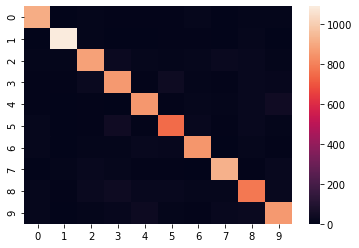

<Figure size 432x288 with 0 Axes>

In [35]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# preprocess the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
trainX = trainX.astype('float')/255.0

testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])
testX = testX.astype('float')/255.0

# build the classifier
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=None))

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

G:\Miniconda3\envs\DL\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



Training Classification Report:

               precision    recall  f1-score   support

           0       0.36      0.34      0.35      5000
           1       0.34      0.34      0.34      5000
           2       0.20      0.10      0.14      5000
           3       0.23      0.12      0.16      5000
           4       0.23      0.20      0.21      5000
           5       0.29      0.27      0.28      5000
           6       0.29      0.55      0.38      5000
           7       0.35      0.30      0.32      5000
           8       0.39      0.47      0.43      5000
           9       0.38      0.48      0.42      5000

    accuracy                           0.32     50000
   macro avg       0.31      0.32      0.30     50000
weighted avg       0.31      0.32      0.30     50000


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.33      0.33      0.33      1000
           1       0.33      0.33      0.33      1000
         

<Figure size 432x288 with 0 Axes>

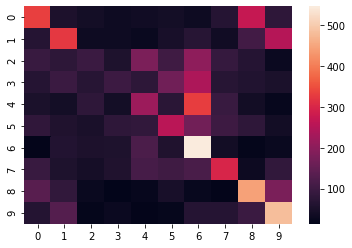

<Figure size 432x288 with 0 Axes>

In [32]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

# preprocess the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2] * 3)
trainX = trainX.astype('float')/255.0

testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2] * 3)
testX = testX.astype('float')/255.0

# build the classifier
model = AdaBoostClassifier()

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()